In this notebook you will find an example of transfer learning using VGG16 and SVM. We extract the features after the transfer learning of the VGG16 architecture abd then train a SVM to make the classification from these extracted features.

Before starting the TP, make sure that you are on a GPU environment:

Exécution -> Modifier le type d'exécution -> Accélerateur matériel = GPU

In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Part 1 : VGG16 Architecture

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl

# Bonus : Classifier some examples with VGG16 and comment on the results in your report.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2021-12-01 15:56:07--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl [following]
--2021-12-01 15:56:07--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.001s  

2021-12-01 15:56:07 (46.5 MB/s) -

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

285


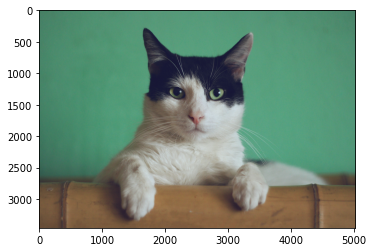

In [ ]:
cat = Image.open('cat.jpg')
#dog = Image.open('dog.jpg')
plt.imshow(cat)
#plt.imshow(dog)
# Add your images
# YOUR CODE HERE for the bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("cat.jpg")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize(mean, std)
])

x = transform_norm(img)
vgg16.eval()
y = vgg16(x.unsqueeze(0))
#y = y.detach().numpy() # transformation to array numpy
print(torch.argmax(y).item())

# Part 2: Transfer Learning with VGG16 on 15 Scene

In [ ]:
!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!unzip 15ScenesData.zip

--2021-12-01 15:56:20--  https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip [following]
--2021-12-01 15:56:20--  https://raw.githubusercontent.com/cdancette/deep-learning-polytech-tp6-7/master/tp8/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   187MB/s    in 0.4s    

2021-12-01 15:56:23 (187 MB/s) - ‘15Scene

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0042.jpg  image_0082.jpg  image_0124.jpg  image_0170.jpg
image_0004.jpg  image_0043.jpg  image_0084.jpg  image_0128.jpg  image_0175.jpg
image_0006.jpg  image_0047.jpg  image_0086.jpg  image_0130.jpg  image_0176.jpg
image_0007.jpg  image_0049.jpg  image_0087.jpg  image_0131.jpg  image_0180.jpg
image_0008.jpg  image_0050.jpg  image_0088.jpg  image_0134.jpg  image_0182.jpg
image_0011.jpg  image_0052.jpg  image_0090.jpg  image_0135.jpg  image_0189.jpg
image_0013.jpg  image_0053.jpg  image_0092.jpg  image_0138.jpg  image_0190.jpg
image_0014.jpg  image_0054.jpg  image_0093.jpg  image_0140.jpg  image_0191.jpg
image_0016.jpg  image_0056.jpg  image_0095.jpg  image_0141.jpg  image_0192.jpg
image_0017.jpg  image_0059.jpg  image_0096.jpg  image_0142.jpg  image_0195.jpg
image_0018.jpg  image_0060.jpg  image_0097.jpg  image_0144.jpg  image_0196.jpg
image_0019.jpg  image_0062.jpg  image_0098.jpg  image_0148.jpg  image_0200.jpg
image_0020.jpg  image_0063.jpg  image_0103.jpg  imag

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # This function allows us to copy an image 3 times and thus "transform" a 
    # black and white image with 1 channel into an RGB image with 3 channels.
    # Use it with transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Your code here  ##
    #####################
    # Add pre-processing
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
                  transforms.Lambda(lambda x: duplicateChannel(x)),
                  transforms.ToTensor(),
                  transforms.Resize((224,224)),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([
                  transforms.Lambda(lambda x: duplicateChannel(x)),
                  transforms.ToTensor(),
                  transforms.Resize((224,224)),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
              ]))
    ####################
    ##      END        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## Your code here  ##
    #####################
    # init features matrices
    X = None
    y = None
    ####################
    ##      END        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Your code here  ##
        #####################
        # todo feature extraction
        if i == 0:
          X = model(input).detach().cpu().numpy()
          y = target
        else:
          X = np.concatenate((X, model(input).detach().cpu().numpy()))
          y = np.concatenate((y, target))



        ####################
        ##      END        #
        ####################    

    return X, y

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


def main(path="15SceneData", batch_size=8):
    print('Initializing VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Initializing VGG16relu7')
    #####################
    ## Your code here  ##
    #####################
    # Replace with a truncated network to perform feature extraction
    # We will create a new class VGG16relu here.

    model = vgg16 
    ####################
    ##      END        #
    ####################      
    
    model.eval()
    if CUDA: # If we have GPU, use CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # Obtain the data
    print('Obtaining data')
    train, test = get_dataset(batch_size, path)

    # Feature Extraction
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Your code here  ##
    #####################
    # Training and evaluation of SVMs here
    print('Training SVMs')
    svm = SVC()
    parameters = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.1, 1, 10, 100]}
    clf = GridSearchCV(svm, parameters)
    clf.fit(X_train, y_train)
    print(clf.best_params_)

    accuracyTrain = clf.score(X_train, y_train)
    accuracyTest = clf.score(X_test, y_test)
    ####################
    ##      END        #
    ####################    
    print('Accuracy train = %f' % accuracyTrain)
    print('Accuracy test = %f' % accuracyTest)


In [ ]:
main("15SceneData", 8)

Initializing VGG16
Initializing VGG16relu7
Obtaining data
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Training SVMs
{'C': 1, 'kernel': 'rbf'}
Accuracy train = 0.935333
Accuracy test = 0.872697
